In [3]:
# find all authors in comment
# complete the book's list

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [39]:
url = 'drive/MyDrive/a/'
url = ''

# Preprocessing

## Importing Libraries

In [40]:
# !pip install hazm swifter

In [41]:
import pandas as pd
import swifter
from tqdm.notebook import tqdm
import numpy as np
import re
from hazm import InformalNormalizer, Normalizer, word_tokenize
import plotly.express as px

## preprocessing prepared data (taghche.csv)

In [42]:
tqdm.pandas()

In [43]:
prepared_data: pd.DataFrame = pd.read_csv(url + 'datasets/taghche.csv')
prepared_data = prepared_data[['comment', 'bookname']]

In [44]:
prepared_data.head()

comment  \
0  اسم کتاب   No one writes to the Colonel\nترجمش...   
1  طاقچه عزیز،نام کتاب"کسی به سرهنگ نامه نمینویسد...   
2  بنظرم این اثر مارکز خیلی از صد سال تنهایی که ب...   
3  به نظر کتاب خوبی میومد اما من از ترجمش خوشم نی...   
4                                      کتاب خوبی است   

                            bookname  
0  سرهنگ کسی ندارد برایش نامه بنویسد  
1  سرهنگ کسی ندارد برایش نامه بنویسد  
2  سرهنگ کسی ندارد برایش نامه بنویسد  
3  سرهنگ کسی ندارد برایش نامه بنویسد  
4  سرهنگ کسی ندارد برایش نامه بنویسد

In [45]:
chars_stop_words = ''
with open(url + 'stopwords/chars.txt', 'r', encoding='utf-8') as file:
    chars_stop_words = ''.join(file.read().splitlines())

chars_stop_words = chars_stop_words.replace('[', '\[')
chars_stop_words = chars_stop_words.replace(']', '\]')
chars_pattern = re.compile(f'[{chars_stop_words}]')
chars_pattern

re.compile(r'[\ufeff!"#()*,-./:\[\]«»،؛؟۰۱۲۳۴۵۶۷۸۹…$ًٌٍَُِّْءٰٔ﷼]', re.UNICODE)

In [46]:
# https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
emojis_pattern = re.compile("["
                            u"\U0001F600-\U0001F64F"  # emoticons
                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            "]+")
emojis_pattern

re.compile(r'[😀-🙏🌀-🗿🚀-\U0001f6ff\U0001f1e0-🇿]+', re.UNICODE)

In [47]:
def elementary_preprocess(text):
    global chars_pattern, emojis_pattern

    text = str(text)
    text = chars_pattern.sub(r' ', text)
    return emojis_pattern.sub(r' ', text)


def higher_preprocess(text):
    # global progress_bar

    text = str(text)
    result = word_tokenize(text)
    # result = informal_normalizer_function(text)
    # progress_bar.update(1)
    return result


# customizing InformalNormalizer().normalize()
# For seeing differences, you can see InformalNormalizer().normalize() method
def informal_normalizer_function(text):
    text = str(text)

    informal_normalizer = InformalNormalizer()
    text = Normalizer.normalize(informal_normalizer, text)
    sents = [
        informal_normalizer.word_tokenizer.tokenize(sentence)
        for sentence in informal_normalizer.sent_tokenizer.tokenize(text)
    ]

    normalized = [[informal_normalizer.normalized_word(word)[0] for word in sent] for sent in sents]
    normalized = np.array(normalized, dtype=object)
    return np.hstack(normalized)

In [48]:
elementary_preprocess_comment = prepared_data['comment'].progress_apply(elementary_preprocess)

  0%|          | 0/69829 [00:00<?, ?it/s]

In [49]:
# elementary_preprocess_comment.to_csv('datasets/preprocessed/elementary_preprocess_comment.csv', index=False)
# elementary_preprocess_comment = pd.read_csv('datasets/preprocessed/elementary_preprocess_comment.csv')

In [50]:
# When you want to do informal normalization, uncomment following lines
# progress_bar = tqdm(total=len(elementary_preprocess_comment))
# higher_preprocess_comment = elementary_preprocess_comment.swifter.apply(higher_preprocess)

higher_preprocess_comment = elementary_preprocess_comment.progress_apply(higher_preprocess)

  0%|          | 0/69829 [00:00<?, ?it/s]

In [51]:
# higher_preprocess_comment.to_csv('datasets/preprocessed/higher_preprocess_comment.csv', index=False)
# informal_normalizer_comment = pd.read_csv('datasets/preprocessed/informal_normalizer_comment.csv')

In [52]:
prepared_data['comment'] = higher_preprocess_comment

In [53]:
before_dropping = len(prepared_data)
prepared_data = prepared_data[prepared_data['comment'].apply(lambda x: len(x)) != 0]
print(f'Dropped {before_dropping - len(prepared_data)} rows with empty comment.')

Dropped 441 rows with empty comment.


In [54]:
prepared_data.head()

comment  \
0  [اسم, کتاب, No, one, writes, to, the, Colonel,...   
1  [طاقچه, عزیز, نام, کتاب, کسی, به, سرهنگ, نامه,...   
2  [بنظرم, این, اثر, مارکز, خیلی, از, صد, سال, تن...   
3  [به, نظر, کتاب, خوبی, میومد, اما, من, از, ترجم...   
4                                  [کتاب, خوبی, است]   

                            bookname  
0  سرهنگ کسی ندارد برایش نامه بنویسد  
1  سرهنگ کسی ندارد برایش نامه بنویسد  
2  سرهنگ کسی ندارد برایش نامه بنویسد  
3  سرهنگ کسی ندارد برایش نامه بنویسد  
4  سرهنگ کسی ندارد برایش نامه بنویسد

## preprocessing crawled data (books_data_part_*.csv)

In [55]:
ALL_PARTS_LEN = 18
crawled_data: pd.DataFrame = pd.read_csv(url + 'datasets/books data/books_data_part_1.csv')
for i in range(2, ALL_PARTS_LEN + 1):
    crawled_data = pd.concat([crawled_data, pd.read_csv(url + f'datasets/books data/books_data_part_{i}.csv')],
                             ignore_index=True)

In [56]:
# sort authors in order to drop duplicates
new_author_function = lambda x: ' $ '.join(sorted(str(x).split(' $ ')))
crawled_data['author'] = crawled_data['author'].apply(new_author_function)

In [57]:
before_dropping = len(crawled_data)
crawled_data = crawled_data.drop_duplicates()
print(f'Dropped {before_dropping - len(crawled_data)} duplicates.')

Dropped 2256 duplicates.


In [58]:
before_dropping = len(crawled_data)
crawled_data = crawled_data.dropna(subset=['name'])
print(f'Dropped {before_dropping - len(crawled_data)} rows with NaN name.')

Dropped 1 rows with NaN name.


In [59]:
new_author_function = lambda x: set(x.split(' $ '))
crawled_data['author'] = crawled_data['author'].apply(new_author_function)

In [60]:
# convert each author to an independent row
# because I want to find each author independently in the comments
crawled_data = crawled_data.explode('author')
crawled_data = crawled_data.reset_index(drop=True)

In [61]:
# crawled_data.to_csv('datasets/preprocessed/crawled_data.csv', index=False)
# crawled_data = pd.read_csv('datasets/preprocessed/crawled_data.csv')

In [62]:
crawled_data.head()

name             author  \
0          هفت گام برای شروع موفق یک کسب و کار           نعیم ظفر   
1                                  آرزوی شهادت  سید اسماعیل گوهری   
2                  شرق - ۱۳۹۵ سه شنبه ۱۸ خرداد                nan   
3          محمدعلی فروغی و ساختارهای نوین مدنی     علی‌اصغر حقدار   
4  روزنامه سازندگی ـ شماره ۹۵۷ ـ ۲۲ خرداد ۱۴۰۰                nan   

                 translator                     publisher  
0  محسن؛ سحر حاجیانی؛ بحریه  انتشارات سازمان مدیریت صنعتی  
1                       NaN   انتشارات علمی فرهنگی الحیاة  
2                       NaN                   روزنامه شرق  
3                       NaN                 انتشارات کویر  
4                       NaN               روزنامه سازندگی

## Merging prepared and crawled data

In [63]:
data: pd.DataFrame = pd.merge(prepared_data, crawled_data, left_on='bookname', right_on='name')
data = data.drop(columns=['bookname'])

In [64]:
print(f'Prepared data: {len(prepared_data)}\nCrawled data: {len(crawled_data)}\nMerged data: {len(data)}')
data.head()

Prepared data: 69388
Crawled data: 198123
Merged data: 216630


comment  \
0  [اسم, کتاب, No, one, writes, to, the, Colonel,...   
1  [طاقچه, عزیز, نام, کتاب, کسی, به, سرهنگ, نامه,...   
2  [بنظرم, این, اثر, مارکز, خیلی, از, صد, سال, تن...   
3  [به, نظر, کتاب, خوبی, میومد, اما, من, از, ترجم...   
4                                  [کتاب, خوبی, است]   

                                name               author    translator  \
0  سرهنگ کسی ندارد برایش نامه بنویسد  گابریل گارسیا مارکز  نازنین نوذری   
1  سرهنگ کسی ندارد برایش نامه بنویسد  گابریل گارسیا مارکز  نازنین نوذری   
2  سرهنگ کسی ندارد برایش نامه بنویسد  گابریل گارسیا مارکز  نازنین نوذری   
3  سرهنگ کسی ندارد برایش نامه بنویسد  گابریل گارسیا مارکز  نازنین نوذری   
4  سرهنگ کسی ندارد برایش نامه بنویسد  گابریل گارسیا مارکز  نازنین نوذری   

                     publisher  
0  موسسه فرهنگی هنری نوروز هنر  
1  موسسه فرهنگی هنری نوروز هنر  
2  موسسه فرهنگی هنری نوروز هنر  
3  موسسه فرهنگی هنری نوروز هنر  
4  موسسه فرهنگی هنری نوروز هنر

In [65]:
data.to_csv('datasets/preprocessed/data.csv', index=False)
# data = pd.read_csv('datasets/preprocessed/data.csv')

In [66]:
crawled_books = set(crawled_data['name'].values)
prepared_books = prepared_data['bookname'].values

unavailable_books = [book for book in prepared_books if book not in crawled_books]
print(f'Unavailable books: {len(unavailable_books)}')

Unavailable books: 8068


# Labeling

In [67]:
labeled_data = data.copy()
labeled_data['label'] = [[0]] * len(labeled_data)
labeled_data.head()

comment  \
0  [اسم, کتاب, No, one, writes, to, the, Colonel,...   
1  [طاقچه, عزیز, نام, کتاب, کسی, به, سرهنگ, نامه,...   
2  [بنظرم, این, اثر, مارکز, خیلی, از, صد, سال, تن...   
3  [به, نظر, کتاب, خوبی, میومد, اما, من, از, ترجم...   
4                                  [کتاب, خوبی, است]   

                                name               author    translator  \
0  سرهنگ کسی ندارد برایش نامه بنویسد  گابریل گارسیا مارکز  نازنین نوذری   
1  سرهنگ کسی ندارد برایش نامه بنویسد  گابریل گارسیا مارکز  نازنین نوذری   
2  سرهنگ کسی ندارد برایش نامه بنویسد  گابریل گارسیا مارکز  نازنین نوذری   
3  سرهنگ کسی ندارد برایش نامه بنویسد  گابریل گارسیا مارکز  نازنین نوذری   
4  سرهنگ کسی ندارد برایش نامه بنویسد  گابریل گارسیا مارکز  نازنین نوذری   

                     publisher label  
0  موسسه فرهنگی هنری نوروز هنر   [0]  
1  موسسه فرهنگی هنری نوروز هنر   [0]  
2  موسسه فرهنگی هنری نوروز هنر   [0]  
3  موسسه فرهنگی هنری نوروز هنر   [0]  
4  موسسه فرهنگی هنری نوروز هنر   [0]

In [68]:
tags = ['name', 'author', 'translator', 'publisher']

In [69]:
def get_label(tag):
    if tag == 'name':
        return 'Book'
    elif tag == 'author':
        return 'Author'
    elif tag == 'translator':
        return 'Translator'
    elif tag == 'publisher':
        return 'Publisher'
    else:
        return None


def convert_index_to_label(index, tag):
    labels = []

    for i in range(len(index)):
        if index[i] == -1:
            labels.append('O')
        else:
            if i == 0 or index[i - 1] == -1 or index[i] - index[i - 1] != 1:
                labels.append(f'B-{get_label(tag)}')
            else:
                labels.append(f'I-{get_label(tag)}')

    return labels


def combine_labels(labels):
    global tags

    result = []

    for i in range(len(labels[tags[0]])):
        name = labels[tags[0]][i] if len(labels[tags[0]]) > 0 else 'O'
        author = labels[tags[1]][i] if len(labels[tags[1]]) > 0 else 'O'
        translator = labels[tags[2]][i] if len(labels[tags[2]]) > 0 else 'O'
        publisher = labels[tags[3]][i] if len(labels[tags[3]]) > 0 else 'O'

        if name != 'O':
            result.append(name)
        elif author != 'O':
            result.append(author)
        elif translator != 'O':
            result.append(translator)
        elif publisher != 'O':
            result.append(publisher)
        else:
            result.append('O')

    return result


def get_labels(row):
    indexes = {
        tag: []
        for tag in tags
    }
    labels = {
        tag: []
        for tag in tags
    }

    for tag in tags:
        cell = row[tag]
        if cell == {np.nan}:
            continue
        cell_list = str(cell).split(' ')

        filled_indexes = set()
        for word in row['comment']:
            try:
                current_index = cell_list.index(word)
                if current_index in filled_indexes:
                    raise ValueError
                indexes[tag].append(current_index)
                filled_indexes.add(current_index)
            except ValueError:
                indexes[tag].append(-1)

        labels[tag] = convert_index_to_label(indexes[tag], tag)

    return combine_labels(labels)

In [70]:
labeled_data['label'] = labeled_data.progress_apply(get_labels, axis=1)

  0%|          | 0/216630 [00:00<?, ?it/s]

In [71]:
# labeled_data.to_csv('datasets/preprocessed/labeled_data.csv', index=False)
# labeled_data = pd.read_csv('datasets/preprocessed/labeled_data.csv')

In [72]:
labeled_data.head()

comment  \
0  [اسم, کتاب, No, one, writes, to, the, Colonel,...   
1  [طاقچه, عزیز, نام, کتاب, کسی, به, سرهنگ, نامه,...   
2  [بنظرم, این, اثر, مارکز, خیلی, از, صد, سال, تن...   
3  [به, نظر, کتاب, خوبی, میومد, اما, من, از, ترجم...   
4                                  [کتاب, خوبی, است]   

                                name               author    translator  \
0  سرهنگ کسی ندارد برایش نامه بنویسد  گابریل گارسیا مارکز  نازنین نوذری   
1  سرهنگ کسی ندارد برایش نامه بنویسد  گابریل گارسیا مارکز  نازنین نوذری   
2  سرهنگ کسی ندارد برایش نامه بنویسد  گابریل گارسیا مارکز  نازنین نوذری   
3  سرهنگ کسی ندارد برایش نامه بنویسد  گابریل گارسیا مارکز  نازنین نوذری   
4  سرهنگ کسی ندارد برایش نامه بنویسد  گابریل گارسیا مارکز  نازنین نوذری   

                     publisher  \
0  موسسه فرهنگی هنری نوروز هنر   
1  موسسه فرهنگی هنری نوروز هنر   
2  موسسه فرهنگی هنری نوروز هنر   
3  موسسه فرهنگی هنری نوروز هنر   
4  موسسه فرهنگی هنری نوروز هنر   

                                               label  
0  [O, O, O, O, O, O, O, O, O, O, B-Book, O, B-Bo...  
1  [O, O, O, O, B-Book, O, B-Book, B-Book, O, O, ...  
2  [O, O, O, B-Author, O, O, O, O, O, O, O, O, O,...  
3  [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...  
4                                          [O, O, O]

In [73]:
labeled_data[labeled_data['comment'].apply(lambda x: len(x)) == 0][:10]

Empty DataFrame
Columns: [comment, name, author, translator, publisher, label]
Index: []

In [74]:
# percentage of O in list histogram
fig = px.histogram([len([tag for tag in label if tag == 'O']) / len(label) for label in labeled_data['label']], title='Percentage of O in List Histogram')
# fig.update_layout(showlegend=False)
fig.show()

# Training The Model (LSTM/CRF)

## Importing Libraries

In [75]:
# !pip install tensorflow tensorflow_addons keras livelossplot
# !pip install git+https://www.github.com/keras-team/keras-contrib.git

In [76]:
# !pip install numpy==1.23

In [77]:
# !mkdir logs

In [78]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, TimeDistributed, Dropout, Bidirectional, InputLayer, Input
from tensorflow_addons.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from livelossplot.tf_keras import PlotLossesCallback

In [79]:
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.13.1
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Exploring Data

In [80]:
# labeled_data = pd.read_csv('datasets/preprocessed/labeled_data.csv')

In [81]:
words = list(set([word for comment in labeled_data['comment'] for word in comment]))
words.append("ENDPAD")
words_size = len(words)
words_size

73502

In [82]:
tags = sorted(list(set([tag for label in labeled_data['label'] for tag in label])))
tags_size = len(tags)
tags_size, tags

(9,
 ['B-Author',
  'B-Book',
  'B-Publisher',
  'B-Translator',
  'I-Author',
  'I-Book',
  'I-Publisher',
  'I-Translator',
  'O'])

In [83]:
# fig = px.histogram([tag for label in labeled_data['label'] for tag in label], title='Tag Distribution with O')
# fig.update_layout(showlegend=False)
# fig.show()

In [84]:
# fig = px.histogram([tag for label in labeled_data['label'] for tag in label if tag != 'O'], title='Tag Distribution without O')
# fig.update_layout(showlegend=False)
# fig.show()

In [85]:
fig = px.histogram([len(comment) for comment in labeled_data['comment']], title='Comment Length Distribution')
fig.update_layout(showlegend=False)
fig.show()

## Changing Data Format

In [86]:
sentences = labeled_data.progress_apply(lambda row: [(word, label) for word, label in zip(row['comment'], row['label'])], axis=1)

  0%|          | 0/216630 [00:00<?, ?it/s]

In [87]:
# sentences.to_csv('datasets/preprocessed/sentences.csv')
# sentences = pd.read_csv('datasets/preprocessed/sentences.csv')

In [88]:
sentences[0]

[('اسم', 'O'),
 ('کتاب', 'O'),
 ('No', 'O'),
 ('one', 'O'),
 ('writes', 'O'),
 ('to', 'O'),
 ('the', 'O'),
 ('Colonel', 'O'),
 ('ترجمش', 'O'),
 ('میشه', 'O'),
 ('کسی', 'B-Book'),
 ('به', 'O'),
 ('سرهنگ', 'B-Book'),
 ('نامه', 'B-Book'),
 ('نمینویسد', 'O'),
 ('مترجمی', 'O'),
 ('که', 'O'),
 ('اسم', 'O'),
 ('کتابم', 'O'),
 ('اشتباه', 'O'),
 ('ترجمه', 'O'),
 ('میکنه', 'O'),
 ('دیگه', 'O'),
 ('چه', 'O'),
 ('توقعی', 'O'),
 ('از', 'O'),
 ('ترجمه', 'O'),
 ('ی', 'O'),
 ('متن', 'O'),
 ('کتاب', 'O'),
 ('باید', 'O'),
 ('داشته_باشیم', 'O'),
 ('اون', 'O'),
 ('هم', 'O'),
 ('آثار', 'O'),
 ('مارکز', 'B-Author'),
 ('که', 'O'),
 ('همش', 'O'),
 ('جریان', 'O'),
 ('سیال', 'O'),
 ('ذهنه', 'O'),
 ('و', 'O'),
 ('ترجمش', 'O'),
 ('کار', 'O'),
 ('هرکسی', 'O'),
 ('نیست', 'O')]

## Convert Words and Labels to Numbers

In [89]:
word2idx = {word: idx + 1 for idx, word in enumerate(words)}
tag2idx = {tag: idx for idx, tag in enumerate(tags)}
idx2tag = {idx: tag for tag, idx in tag2idx.items()}

In [90]:
tag2idx

{'B-Author': 0,
 'B-Book': 1,
 'B-Publisher': 2,
 'B-Translator': 3,
 'I-Author': 4,
 'I-Book': 5,
 'I-Publisher': 6,
 'I-Translator': 7,
 'O': 8}

## Padding the Sentences

In [91]:
# Based on the 3rd hist.
max_length = 200

X = [[word2idx[word[0]] for word in sentence] for sentence in sentences]
X = pad_sequences(X, maxlen=max_length, padding='post', value=-1)

y = [[tag2idx[word[1]] for word in sentence] for sentence in sentences]
y = pad_sequences(y, maxlen=max_length, padding='post', value=tag2idx['O'])

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [93]:
print(f'Train size: {len(X_train)}\nValidation size: {len(X_val)}\nTest size: {len(X_test)}')

Train size: 173304
Validation size: 21663
Test size: 21663


## Create Bidirectional LSTM/CRF Model

In [98]:
model = Sequential()
model.add(InputLayer(input_shape=(max_length,)))
model.add(Embedding(input_dim=words_size, output_dim=max_length, input_length=max_length)) 
model.add(Dropout(0.1))
# model.add(Bidirectional(LSTM(units=max_length, return_sequences=True)))
model.add(Bidirectional(LSTM(units=max_length, return_sequences=True, recurrent_dropout=0.1)))
# model.add(TimeDistributed(Dense(units=max_length)))
# crf = CRF(units=tags_size)
# model.add(crf)

# input_shape = (max_length,)
# inputs = Input(shape=input_shape)
# x = Embedding(input_dim=words_size, output_dim=max_length, input_length=max_length)(inputs)
# x = Dropout(0.1)(x)
# x = Bidirectional(LSTM(units=max_length, return_sequences=True, recurrent_dropout=0.1))(x)
# x = TimeDistributed(Dense(units=max_length))(x)
# crf = CRF(units=tags_size)
# outputs = crf(x)
# 
# model = Model(inputs=inputs, outputs=outputs)

# model.compile(optimizer='adam', loss=crf_loss, metrics=[crf_viterbi_accuracy])
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 200)          14700400  
                                                                 
 dropout_1 (Dropout)         (None, 200, 200)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 200, 400)          641600    
 onal)                                                           
                                                                 
Total params: 15342000 (58.53 MB)
Trainable params: 15342000 (58.53 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


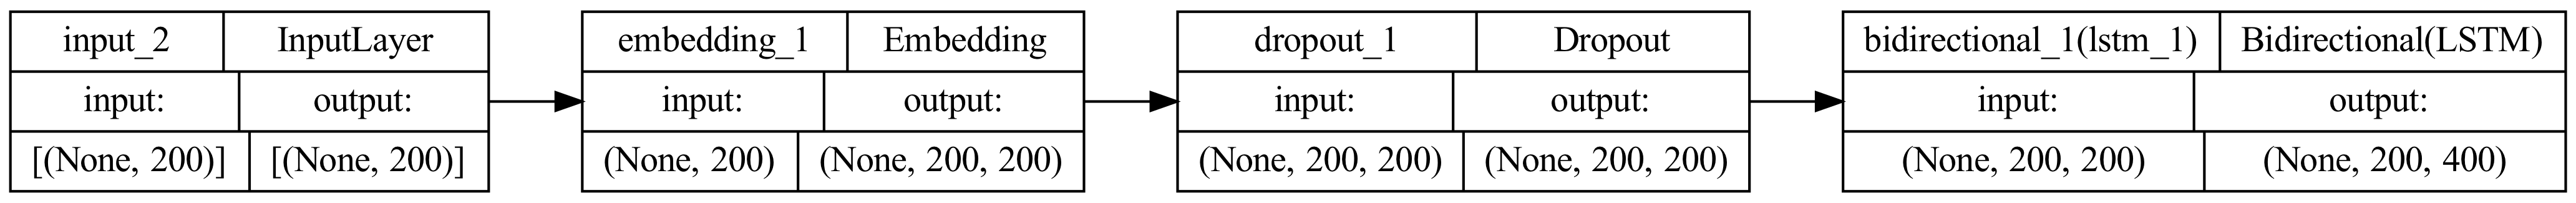

In [99]:
tf.keras.utils.plot_model(
    model, to_file='resources/model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='LR', expand_nested=True, dpi=300,
)

In [100]:
logdir='logs/'
tensorboard_callback = TensorBoard(log_dir=logdir)

model_checkpoint = ModelCheckpoint('resources/model.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
# early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)
plot_losses = PlotLossesCallback()

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=3, verbose=1,
                    callbacks=[tensorboard_callback, model_checkpoint, early_stopping, plot_losses])

Epoch 1/3


2024-07-10 17:09:59.805882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [ ]:
# model.save('resources/model.keras')
# model = tf.keras.models.load_model('resources/model.keras')

In [ ]:
def get_y_pred(X):
    global model, idx2tag
    
    y_pred = model.predict(X)
    y_pred = np.argmax(y_pred, axis=-1)
    y_pred = [[idx2tag[idx] for idx in row] for row in y_pred]
    return y_pred

In [ ]:
sample_X = 'من پارسال موقع عید کتاب جز از کل رو از انتشارات چشمه خوندم باید بگم که موقع خوندنش واقعاً محو قلم استیو تولتز شده بودم.'
sample_X = elementary_preprocess(sample_X)
sample_X = higher_preprocess(sample_X)
sample_X = [[word2idx[word] for word in sample_X]]
sample_X = pad_sequences(sample_X, maxlen=max_length, padding='post', value=words_size - 1)
sample_y = get_y_pred([sample_X])
sample_y

In [ ]:
y_test = np.argmax(y_test, axis=-1)
y_test = [[idx2tag[idx] for idx in row] for row in y_test]
y_pred = get_y_pred(X_test)

print(classification_report(y_test, y_pred))

In [ ]:
X_test[:10]